# Проектная работа

## Установка необходимых библиотек

- numpy - Для работы с большими объёмами данных
- pandas - Для работы с табличными(матричными) структурами
- opencv - cv2 - Для извлечения метрик из изображений

In [1]:
%pip install numpy pandas opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Импорт библиотек
Импортируем все необходимые библиотеки для дальнейшей работы:

In [2]:
import cv2  # для работы с изображениями
import numpy as np  # для численных операций
import os  # для работы с файловой системой
import pandas as pd  # для работы с таблицами данных
import matplotlib.pyplot as plt  # для визуализации
from tqdm import tqdm  # для отображения прогресса
from sklearn.decomposition import PCA  # для метода главных компонент

## Функция сжатия изображения с использованием PCA

In [ ]:
def compress_image_with_pca(img, target_variance=0.95):
    """
    Сжимает изображение с использованием метода главных компонент (PCA)
    
    Параметры:
        img: исходное изображение в формате numpy array
        target_variance: доля сохраняемой дисперсии (по умолчанию 0.95)
        
    Возвращает:
        compressed_img: сжатое изображение
        n_components: количество использованных компонент
        original_size: исходный размер изображения в байтах
        compressed_size: размер сжатого изображения в байтах
    """
    # Разделяем изображение на цветовые каналы
    blue, green, red = cv2.split(img)
    
    # Нормализуем значения пикселей
    blue_norm, green_norm, red_norm = blue/255.0, green/255.0, red/255.0
    
    # Применяем PCA для каждого канала отдельно
    pca_blue = PCA(n_components=target_variance).fit(blue_norm)
    pca_green = PCA(n_components=target_variance).fit(green_norm)
    pca_red = PCA(n_components=target_variance).fit(red_norm)
    
    # Выбираем максимальное количество компонент среди всех каналов
    n_components = max(pca_blue.n_components_, pca_green.n_components_, pca_red.n_components_)
    
    # Создаем объект PCA с выбранным числом компонент
    pca = PCA(n_components=n_components)
    
    # Функция для применения PCA к каналу
    def apply_pca(channel):
        return pca.inverse_transform(pca.fit_transform(channel))
    
    # Применяем PCA к каждому каналу и объединяем обратно
    compressed_img = cv2.merge([
        (apply_pca(blue_norm) * 255).clip(0, 255).astype(np.uint8),
        (apply_pca(green_norm) * 255).clip(0, 255).astype(np.uint8),
        (apply_pca(red_norm) * 255).clip(0, 255).astype(np.uint8)
    ])
    
    # Вычисляем исходный и сжатый размеры
    original_size = img.nbytes
    compressed_size = (blue_norm.shape[0] * n_components * 3 * 8)  # float64 (8 bytes)
    
    return compressed_img, n_components, original_size, compressed_size

### Итерация по всем изображения и сбор данных

In [ ]:
# ==============================================
# 1. НАСТРОЙКА ПУТЕЙ И ПОДГОТОВКА ДИРЕКТОРИЙ
# ==============================================
# Путь к исходным данным (папка с изображениями покемонов)
data_path = 'PokemonData'


# ==============================================
# 2. ИНИЦИАЛИЗАЦИЯ СТРУКТУР ДЛЯ СБОРА СТАТИСТИКИ
# ==============================================
# Список для хранения статистики по первым 10 классам
stats = []
# Список для хранения компонент изображений Pikachu
pikachu_components = []
# Словарь для хранения статистики по всем классам
class_stats = {}

# Общие счетчики размеров
total_org_size = 0        # Суммарный оригинальный размер
total_compressed_size = 0  # Суммарный размер после сжатия


# ==============================================
# 3. ОСНОВНОЙ ЦИКЛ ОБРАБОТКИ ИЗОБРАЖЕНИЙ
# ==============================================
# Получаем список поддиректорий (каждая - отдельный класс покемонов)
class_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# Цикл по всем классам (с индикатором прогресса tqdm)
for class_dir in tqdm(class_dirs, desc="Обработка классов"):
    # Формируем полные пути
    class_path = os.path.join(data_path, class_dir)        # Путь к исходным изображениям класса
    
    # Инициализация статистики для текущего класса
    class_components = []      # Список компонент для всех изображений класса
    # Получаем список изображений (только .png, .jpg, .jpeg)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Счетчики для класса (используются только для первых 10 классов)
    class_org_size = 0     # Суммарный размер до сжатия
    class_comp_size = 0    # Суммарный размер после сжатия
    class_n_comp = 0       # Суммарное количество компонент
    
    # Обработка каждого изображения в классе
    for i, file in enumerate(tqdm(image_files, desc=f"Обработка {class_dir}")):
        img_path = os.path.join(class_path, file)  # Полный путь к изображению
        img = cv2.imread(img_path)                # Загрузка изображения
        
        # Применяем PCA-сжатие (используем вашу функцию)
        compressed_img, n_comp, orig_size, comp_size = compress_image_with_pca(img)

        # Обновляем общие счетчики размеров
        total_org_size += orig_size
        total_compressed_size += comp_size
        
        # Специальная статистика для Pikachu
        if class_dir == 'Pikachu':
            pikachu_components.append(n_comp)
        
        # Собираем статистику по компонентам для класса
        class_components.append(n_comp)
        
        # Для первых 10 классов собираем детальную статистику
        if class_dir in class_dirs[:10]:
            class_comp_size += comp_size
            class_org_size += orig_size
            class_n_comp += n_comp
    
    # После обработки всех изображений класса сохраняем статистику для первых 10 классов
    if class_dir in class_dirs[:10]:
        stats.append({
                'Класс': class_dir,
                'Объём до сжатия (МБ)': round(class_org_size / (1024**2), 2),  # в мегабайтах
                'Объём после сжатия (МБ)': round(class_comp_size / (1024**2), 2),
                'Среднее число компонент': round(class_n_comp / len(image_files), 2)
            })
    
    # Сохраняем статистику по классу (для всех классов)
    if class_components:
        class_stats[class_dir] = {
            'mean_components': np.mean(class_components),  # Среднее число компонент
            'all_components': class_components            # Все значения компонент
        }


# ==============================================
# 4. ВЫВОД ОБЩЕЙ СТАТИСТИКИ ПО ПАМЯТИ
# ==============================================
print(f"╔{'═'*50}╗")
print(f"║ {'Оригинальный размер:':<25} {total_org_size/(1024**2):>10.2f} МБ {'║':>10}")
print(f"║ {'Сжатый размер:':<25} {total_compressed_size/(1024**2):>10.2f} МБ {'║':>10}")
print(f"║ {'Экономия памяти:':<25} {((total_org_size - total_compressed_size)/total_org_size)*100:>10.2f}% {'║':>10}")
print(f"╚{'═'*50}╝")


# ==============================================
# 5. СОХРАНЕНИЕ СТАТИСТИКИ В ФАЙЛ
# ==============================================
# Создаем DataFrame из собранной статистики
df = pd.DataFrame(stats)
# Сохраняем в Excel-файл
df.to_excel('compression_stats.xlsx', index=False)


# ==============================================
# 6. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ (ГИСТОГРАММЫ)
# ==============================================
# 6.1 Гистограмма для Pikachu
plt.figure(figsize=(10, 6))
plt.hist(pikachu_components, bins=40, color='yellow', edgecolor='black')
plt.title('Распределение числа компонент для изображений Pikachu')
plt.xlabel('Число компонент PCA')
plt.ylabel('Количество изображений')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('components_by_image.png', bbox_inches='tight', dpi=300)
plt.close()

# 6.2 Гистограмма распределения средних значений по классам
mean_components = [np.mean(cls['all_components']) for cls in class_stats.values()]

# Создаем диапазоны от 20 до 90 с шагом 5
bin_edges = list(range(20, 91, 5))  # [20, 25, 30, ..., 85, 90]
bin_labels = [f'{i}-{i+4}' for i in range(20, 86, 5)] + ['90+']

plt.figure(figsize=(14, 7))

# Строим гистограмму с заданными бинами
n, bins, patches = plt.hist(mean_components, 
                          bins=bin_edges,
                          color='#1f77b4', 
                          edgecolor='white', 
                          linewidth=1.2,
                          alpha=0.9,
                          rwidth=0.85)

# Добавляем подписи значений
for patch, count in zip(patches, n):
    if count > 0:  # Подписываем только непустые столбцы
        plt.text(patch.get_x() + patch.get_width()/2, 
                patch.get_height() + 0.5, 
                f'{int(count)}',
                ha='center',
                va='bottom',
                fontsize=10)

# Настройка оформления
plt.title('Распределение среднего числа компонент PCA по классам\n(Диапазоны по 5 единиц)', 
         pad=20, fontsize=14)
plt.xlabel('Диапазон числа компонент PCA', fontsize=12, labelpad=10)
plt.ylabel('Количество классов', fontsize=12, labelpad=10)
plt.xticks(bin_edges[:-1], bin_labels, rotation=45, ha='right')
plt.yticks(np.arange(0, max(n)+2, 2))  # Шаг 2 по оси Y
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Улучшаем отступы и сохраняем
plt.tight_layout()
plt.savefig('components_by_class.png', dpi=300, bbox_inches='tight')
plt.close()

# 6.3 Общая гистограмма для всех изображений
all_components = [comp for cls in class_stats.values() for comp in cls['all_components']]

plt.figure(figsize=(10, 6))
plt.hist(all_components, bins=20, color='lightgreen', edgecolor='black')
plt.title('Общее распределение числа компонент для всех изображений')
plt.xlabel('Число компонент PCA')
plt.ylabel('Количество изображений')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('general_components.png', bbox_inches='tight', dpi=300)
plt.close()


# ==============================================
# 7. ФИНАЛЬНЫЙ ВЫВОД ИНФОРМАЦИИ
# ==============================================
print("Обработка завершена!")
print(f"Статистика сохранена в compression_stats.xlsx")
print(f"Графики сохранены в components_by_image.png, components_by_class.png и general_components.png")

Обработка классов:   0%|          | 0/150 [00:00<?, ?it/s]

Обработка классов: 100%|██████████| 150/150 [38:07<00:00, 15.25s/it]


╔══════════════════════════════════════════════════╗
║ Оригинальный размер:         6497.87 МБ          ║
║ Сжатый размер:               3881.98 МБ          ║
║ Экономия памяти:               40.26%          ║
╚══════════════════════════════════════════════════╝
Обработка завершена!
Статистика сохранена в compression_stats.xlsx
Графики сохранены в compression_analysis.png


## Построение дополнительной инфографики для наглядности

### Разбиение изображения Пикачу на цветовые каналы

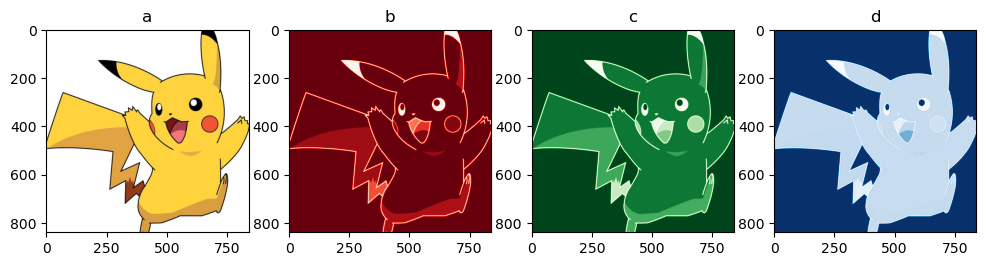

In [9]:
img = cv2.cvtColor(cv2.imread('PokemonData\\Pikachu\\00000072.jpeg'), cv2.COLOR_BGR2RGB)
r, g, b = cv2.split(img)

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(img)
axes[0].set_title('a')
axes[1].imshow(r, cmap='Reds')
axes[1].set_title('b')
axes[2].imshow(g, cmap='Greens')
axes[2].set_title('c')
axes[3].imshow(b, cmap='Blues')
axes[3].set_title('d')

plt.savefig('pikachu_rgb.png', bbox_inches='tight', dpi=150)

### Сравнение исходного изображения и сжатого при помощи PCA

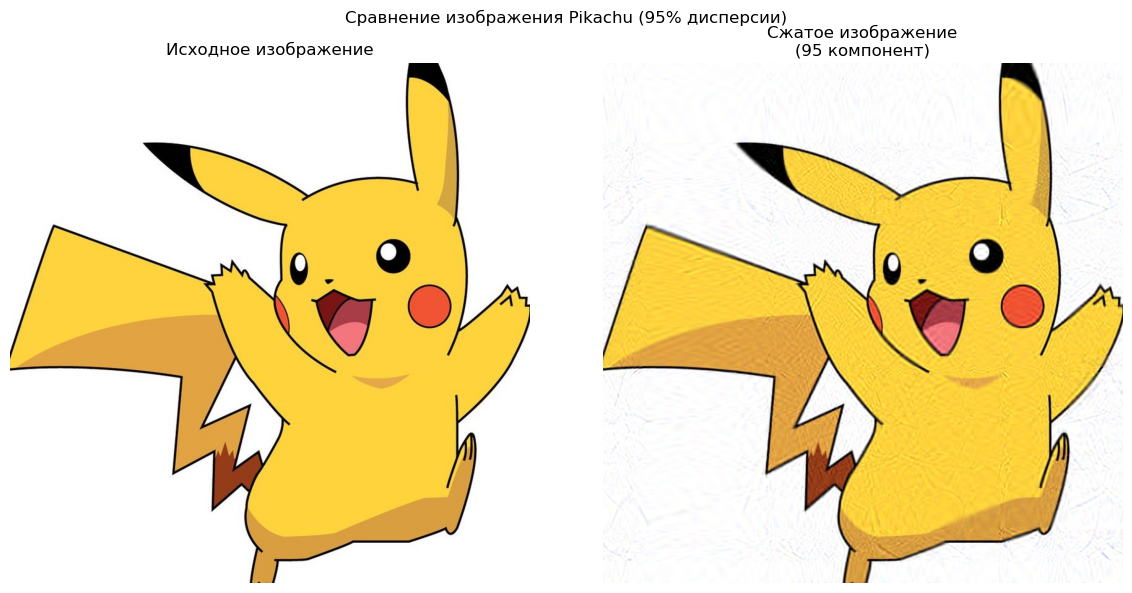

In [8]:
img_path = 'PokemonData\\Pikachu\\00000072.jpeg'
original_img = cv2.imread(img_path)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Конвертация в RGB для matplotlib

# Сжатие изображения
compressed_img, n_components, org_size, comp_size = compress_image_with_pca(original_img)
compressed_img_rgb = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB)

# Визуализация
plt.figure(figsize=(12, 6))

# Исходное изображение
plt.subplot(1, 2, 1)
plt.imshow(original_img_rgb)
plt.title('Исходное изображение')
plt.axis('off')

# Сжатое изображение
plt.subplot(1, 2, 2)
plt.imshow(compressed_img_rgb)
plt.title(f'Сжатое изображение\n({n_components} компонент)')
plt.axis('off')

# Общая информация
plt.suptitle(f'Сравнение изображения Pikachu (95% дисперсии)', y=0.98)
plt.tight_layout()
plt.savefig('pikachu_comparison.png', bbox_inches='tight', dpi=150)
plt.show()

### Построение гистограммы зависимости объяснённой вариации от кол-ва основных компонент

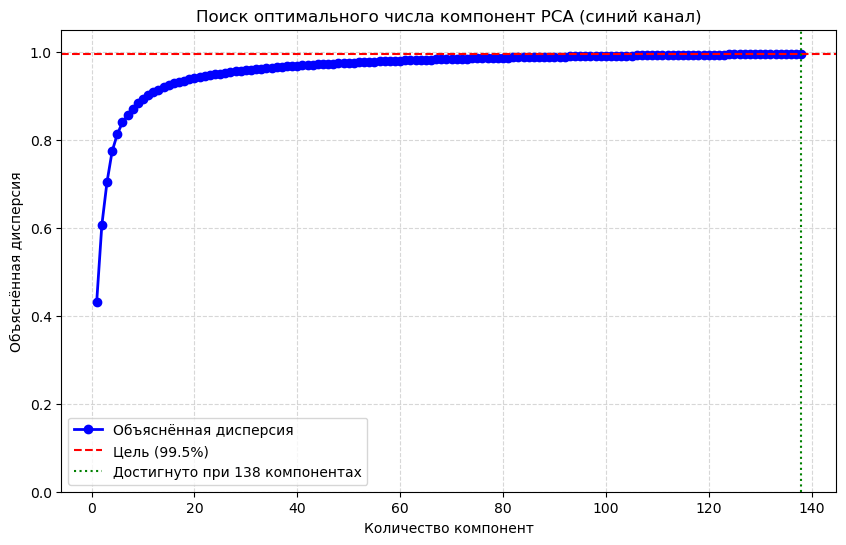

In [3]:
# Загрузка и подготовка изображения
img_path = 'PokemonData\\Pikachu\\00000072.jpeg'
img = cv2.imread(img_path)
blue_channel = img[:, :, 0] / 255.0  # Нормализуем синий канал

# Инициализация переменных
n_components = 1
explained_variance = 0.0
variance_history = []
max_components = min(blue_channel.shape)  # Максимально возможное число компонент

# Цикл поиска оптимального числа компонент
while explained_variance < 0.995 and n_components <= max_components:
    pca = PCA(n_components=n_components)
    pca.fit(blue_channel)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    variance_history.append(explained_variance)
    n_components += 1

# Визуализация прогресса объяснённой дисперсии
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components), variance_history, 
         'b-o', linewidth=2, markersize=6, label='Объяснённая дисперсия')
plt.axhline(y=0.995, color='r', linestyle='--', label='Цель (99.5%)')
plt.axvline(x=n_components-1, color='g', linestyle=':', 
            label=f'Достигнуто при {n_components-1} компонентах')

plt.title('Поиск оптимального числа компонент PCA (синий канал)')
plt.xlabel('Количество компонент')
plt.ylabel('Объяснённая дисперсия')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 1.05)

# Сохраняем гистограмму
plt.savefig('complexity.png', bbox_inches='tight', dpi=120)
plt.show()
plt.close()